# Librerias
---

In [647]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})
import cv2
from tqdm import tqdm
import os
import glob

# Carga de datos
---

In [617]:
df = pd.read_csv("../../data/train.csv")
df

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


# Análisis exploratorio
---

El dataset contiene las siguientes columnas:
* id: Contiene el caso, el día y el número de imágen.
* segmentation: para algunas imágenes, se describe la mascara que segmenta algun organo en especifico.
* class: Organo que se esta segmentando. 

Usando la funciones basicas de pandas se puede observar que:
* Existen 3 clases, "large_bowel", "small_bowel"  y "stomach", que representan al intestino grueso, intestino delgado, y el estomago respectivamente,
* El dataset contiene 115.488 datos, de los cuales existen 38.496 ids unicos, esto se debe a que para cada imágen hay 3 organos segmentados.
* De los 115.488 datos, solamente 33.913 cuentan con una mascara de segmentación, el resto de datos son NaN.

In [618]:
df.describe()

,id,class,segmentation
count,115488,115488,33913
unique,38496,3,33899
top,case123_day20_slice_0001,large_bowel,12629 10 12894 12 13158 15 13423 17 13688 19 1...
freq,3,38496,2


In [619]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


In [620]:
df["class"].unique()

array(['large_bowel', 'small_bowel', 'stomach'], dtype=object)

Descomponiendo la información suministrada por el id, se puede encontrar información sobre el número de casos, número de días, y la cantidad de imágenes por cada caso:

Adicionalmente, en el nombre de los archivos se encuentra información sobre el alto y ancho en pixeles, y el espaciado entre pixeles en milimetros.
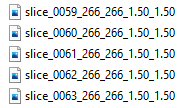
A continuación se extrae la información del tamño y se añade al dataset.

In [621]:
def parse_int(s):
    i = j = 0
    while i < len(s):
        while j < len(s) and s[j].isdigit():
            j += 1
        if i < j:
            return int(s[i:j])
        i = j = j + 1
    return math.nan

def extract_image_info(path):
    case_day, fname = path.rsplit("\\", maxsplit=3)[1::2]
    case, day = case_day.split("_")
    slice, height, width = fname.split("_", maxsplit=4)[1:4]
    info = [f"{case}_{day}_slice_{slice}"]
    numeric_info = [case, day, slice, height, width]
    info.extend([parse_int(info) for info in numeric_info])
    return info
    
def create_image_df(path):
    paths = glob.glob(f"{TRAIN_DIR}/**/*.png", recursive=True)
    df = pd.DataFrame({"path": paths})
    info_cols = ["id", "case", "day", "slice", "height", "width"]
    df[info_cols] = df.apply(
        lambda row: extract_image_info(row.path), 
        axis=1,
        result_type="expand"
    )
    return df

TRAIN_DIR = "../../data/train"
data = create_image_df(TRAIN_DIR)
data

,path,id,case,day,slice,height,width
0,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0001,101,20,1,266,266
1,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0002,101,20,2,266,266
2,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0003,101,20,3,266,266
3,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0004,101,20,4,266,266
4,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0005,101,20,5,266,266
...,...,...,...,...,...,...,...
38491,../../data/train\case92\case92_day0\scans\slic...,case92_day0_slice_0140,92,0,140,266,266
38492,../../data/train\case92\case92_day0\scans\slic...,case92_day0_slice_0141,92,0,141,266,266
38493,../../data/train\case92\case92_day0\scans\slic...,case92_day0_slice_0142,92,0,142,266,266
38494,../../data/train\case92\case92_day0\scans\slic...,case92_day0_slice_0143,92,0,143,266,266


De la siguiente grafica se puede observar que el caso más extenso es el 36, pues este cuente con un mayor número de imágenes. Además, existen casos faltantes que se deben a que el dataset es el destinado a entrenamiento ofrecido por kaggle.

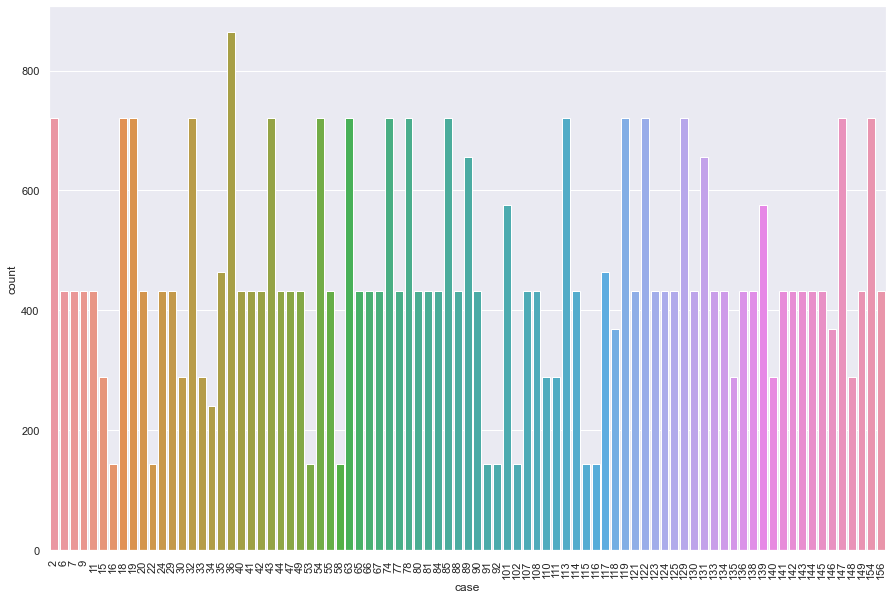

In [622]:
ax = sns.countplot(x="case", data=data)
ax.tick_params(axis='x', rotation=90)

Agrupando el dataset por casos se observa que se cuenta con 156 pacientes junto con la cantidad de días totales

In [623]:
data_case = data.groupby(['case']).max()
data_case

,path,id,day,slice,height,width
case,,,,,,
2,../../data/train\case2\case2_day5\scans\slice_...,case2_day5_slice_0144,5,144,266,266
6,../../data/train\case6\case6_day24\scans\slice...,case6_day24_slice_0144,24,144,360,310
7,../../data/train\case7\case7_day19\scans\slice...,case7_day19_slice_0144,19,144,266,266
9,../../data/train\case9\case9_day22\scans\slice...,case9_day22_slice_0144,22,144,360,310
11,../../data/train\case11\case11_day13\scans\sli...,case11_day13_slice_0144,13,144,360,310
...,...,...,...,...,...,...
147,../../data/train\case147\case147_day20\scans\s...,case147_day20_slice_0144,20,144,360,310
148,../../data/train\case148\case148_day20\scans\s...,case148_day20_slice_0144,20,144,360,310
149,../../data/train\case149\case149_day15\scans\s...,case149_day15_slice_0144,15,144,266,266


De la grafica se observa que los valores más comunes son 0 y 20 días con 9 casos cada uno, segido por 16 días con 8.

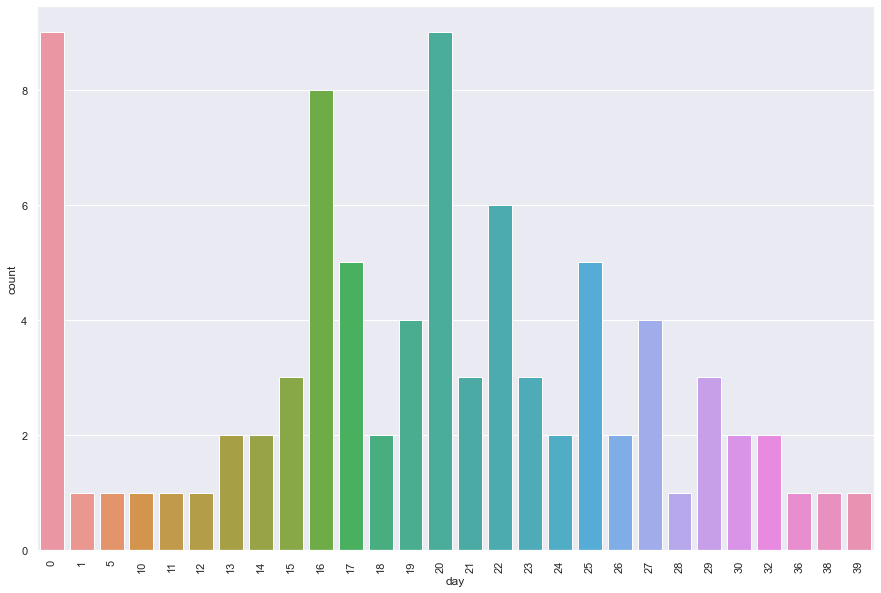

In [624]:
ax = sns.countplot(x="day", data=data_case)
ax.tick_params(axis='x', rotation=90)

En cuanto a la cantidad de imagenes, se observa que la mayoría de casos cuentan con 144 imágenes por día.

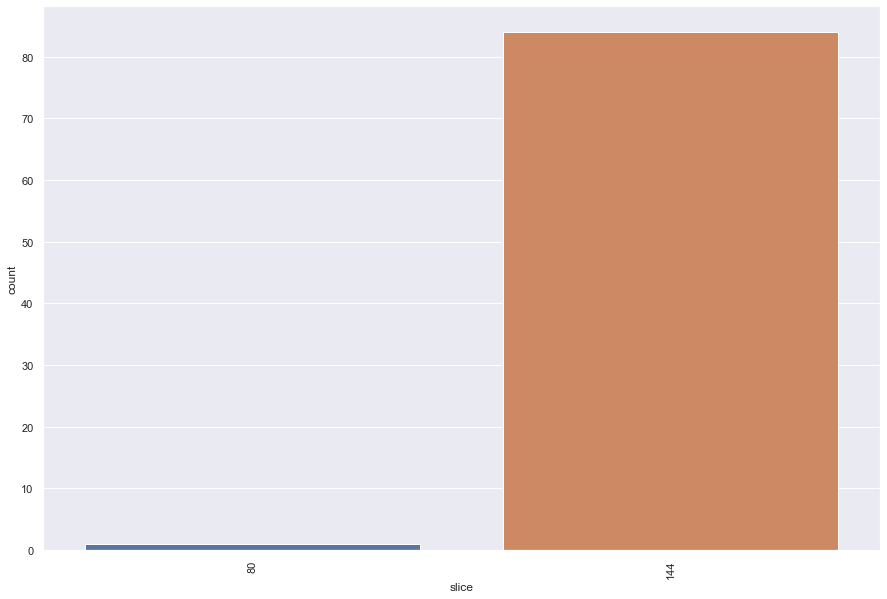

In [625]:
ax = sns.countplot(x="slice", data=data_case)
ax.tick_params(axis='x', rotation=90)

Agrupando el dataset por id, es posible encontrar información sobre las dimenciones de las imágenes.

In [626]:
data_images = data.groupby(['id']).max()
data_images

,path,case,day,slice,height,width
id,,,,,,
case101_day20_slice_0001,../../data/train\case101\case101_day20\scans\s...,101,20,1,266,266
case101_day20_slice_0002,../../data/train\case101\case101_day20\scans\s...,101,20,2,266,266
case101_day20_slice_0003,../../data/train\case101\case101_day20\scans\s...,101,20,3,266,266
case101_day20_slice_0004,../../data/train\case101\case101_day20\scans\s...,101,20,4,266,266
case101_day20_slice_0005,../../data/train\case101\case101_day20\scans\s...,101,20,5,266,266
...,...,...,...,...,...,...
case9_day22_slice_0140,../../data/train\case9\case9_day22\scans\slice...,9,22,140,360,310
case9_day22_slice_0141,../../data/train\case9\case9_day22\scans\slice...,9,22,141,360,310
case9_day22_slice_0142,../../data/train\case9\case9_day22\scans\slice...,9,22,142,360,310


In [627]:
data_images.height.value_counts()

266    25920
360    11232
276     1200
234      144
Name: height, dtype: int64

In [628]:
data_images.width.value_counts()

266    25920
310    11232
276     1200
234      144
Name: width, dtype: int64

Del dataset se observa que hay una misma cantidad de imagenes con determinadas dimensiones, a partir de esto, se puede establecer que los tamaños son:
* 266px x 266px
* 360px x 310px
* 276px x 276px
* 432px x 432px

De las graficas se puede observar que la aproximadamente el tamaño que predomina es de 266px x 266px, seguido por 360px x 310px.

<AxesSubplot:xlabel='width', ylabel='count'>

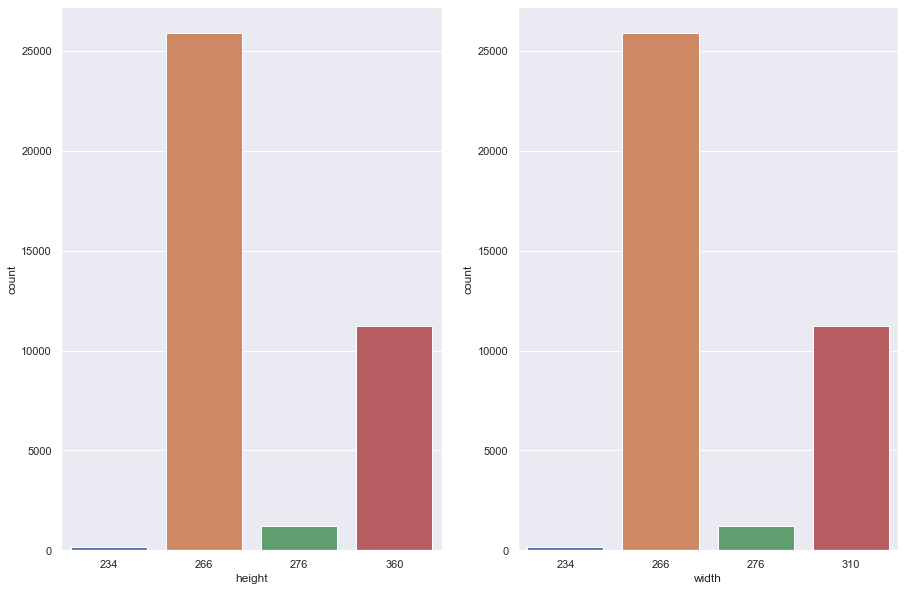

In [629]:
fig, axes = plt.subplots(1, 2)
sns.countplot(ax=axes[0],x="height", data=data_images)
sns.countplot(ax=axes[1],x="width", data=data_images)

Para analizar la segmentación, por facilidad se modifica el dataset para tener ids unicos:

In [630]:
def create_mask_df(df):
    df = df.set_index(["id", "class"]).unstack().reset_index()
    df.columns = "id", 'large_bowel', 'small_bowel', 'stomach'
    df.fillna("", inplace=True)
    return df

segmentation = create_mask_df(df)
data = segmentation.merge(data, on="id", how="left")
data

,id,large_bowel,small_bowel,stomach,path,case,day,slice,height,width
0,case101_day20_slice_0001,,,,../../data/train\case101\case101_day20\scans\s...,101,20,1,266,266
1,case101_day20_slice_0002,,,,../../data/train\case101\case101_day20\scans\s...,101,20,2,266,266
2,case101_day20_slice_0003,,,,../../data/train\case101\case101_day20\scans\s...,101,20,3,266,266
3,case101_day20_slice_0004,,,,../../data/train\case101\case101_day20\scans\s...,101,20,4,266,266
4,case101_day20_slice_0005,,,,../../data/train\case101\case101_day20\scans\s...,101,20,5,266,266
...,...,...,...,...,...,...,...,...,...,...
38491,case9_day22_slice_0140,,,,../../data/train\case9\case9_day22\scans\slice...,9,22,140,360,310
38492,case9_day22_slice_0141,,,,../../data/train\case9\case9_day22\scans\slice...,9,22,141,360,310
38493,case9_day22_slice_0142,,,,../../data/train\case9\case9_day22\scans\slice...,9,22,142,360,310
38494,case9_day22_slice_0143,,,,../../data/train\case9\case9_day22\scans\slice...,9,22,143,360,310


Tomando las imágenes que estan segmentadas:

In [640]:
segment = data[(data["large_bowel"] != "") | (data["small_bowel"] != "") | (data["stomach"] != "")]
segment.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,height,width
65,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,../../data/train\case101\case101_day20\scans\s...,101,20,66,266,266
66,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,../../data/train\case101\case101_day20\scans\s...,101,20,67,266,266
67,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,../../data/train\case101\case101_day20\scans\s...,101,20,68,266,266
68,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,../../data/train\case101\case101_day20\scans\s...,101,20,69,266,266
69,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,../../data/train\case101\case101_day20\scans\s...,101,20,70,266,266


Las máscaras se encuentran codificadas en RLE-encoded, se hace la función que la decodifica y se toman n muestras aleatorias del dataset, se generan las máscaras y se segmenta la imágen:

In [657]:
def generate_mask(seg, shape):
    if seg == "":
        mask = np.zeros(np.prod(shape), dtype=np.uint8)
        return mask
    start_list = seg[0::2]
    length_list = seg[1::2]

    mask = np.zeros(np.prod(shape), dtype=np.uint8)

    for start, length in zip(start_list, length_list):
        start = int(start)
        length = int(length)
        mask[start:start + length] = 255

    mask = np.reshape(mask, shape)
    mask = np.ma.masked_where(mask == 0, mask)
    
    return mask

def get_random_mask(df, n):
    mask_colors = [(0, 0, 1), (1, 0, 0), (1, 0, 1)]
    legend_colors = [Rectangle((0,0),1,1, color=color) for color in mask_colors]
    labels = ["Large Bowel", "Small Bowel", "Stomach"]
    for i in range(n):
        sample = df.sample()
        ids = sample.iloc[0,0].split("_")
        path = sample["path"].iloc[0]
        img = cv2.imread(path, 0)
        
        mask1 = generate_mask(sample.iloc[0, 1].split(), (sample["width"].iloc[0], sample["height"].iloc[0]))
        mask2 = generate_mask(sample.iloc[0, 2].split(), (sample["width"].iloc[0], sample["height"].iloc[0]))
        mask3 = generate_mask(sample.iloc[0, 3].split(), (sample["width"].iloc[0], sample["height"].iloc[0]))
        
        plt.figure()
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(img, cmap='viridis')
        ax1.set_title("Original")
        
        ax2.imshow(mask1, cmap='autumn')
        ax2.imshow(mask2, cmap='winter')
        ax2.imshow(mask3, cmap='spring')
        ax2.set_title("Mascaras")
        ax2.legend(legend_colors, labels)
        
        ax3.imshow(img, cmap='viridis')
        ax3.imshow(mask1, interpolation='none', cmap='autumn', alpha=0.5)
        ax3.imshow(mask2, interpolation='none', cmap='winter', alpha=0.5)
        ax3.imshow(mask3, interpolation='none', cmap='spring', alpha=0.5)
        ax3.set_title("Segmentación")
        
        ax1.axis("off")
        ax2.axis("off")
        ax3.axis("off")
        

<Figure size 1080x720 with 0 Axes>

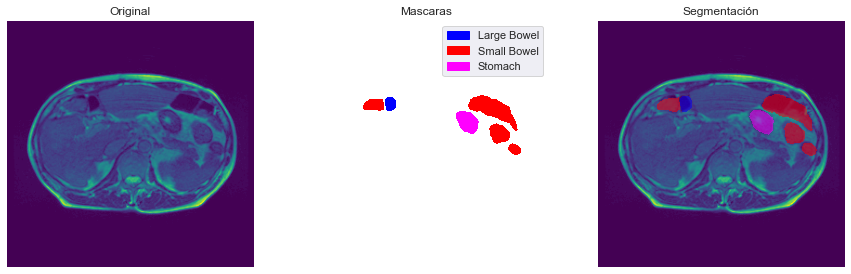

<Figure size 1080x720 with 0 Axes>

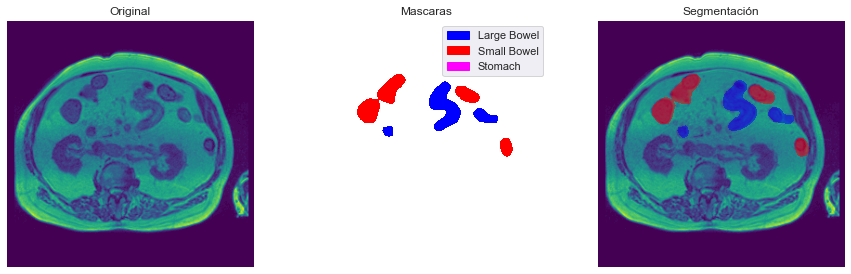

<Figure size 1080x720 with 0 Axes>

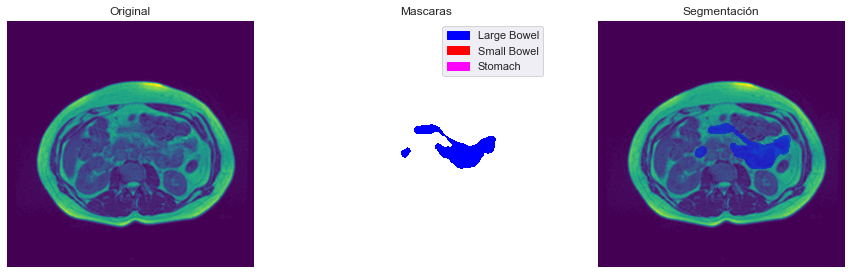

<Figure size 1080x720 with 0 Axes>

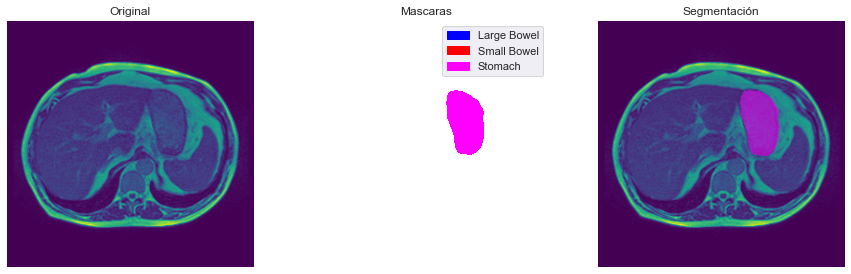

<Figure size 1080x720 with 0 Axes>

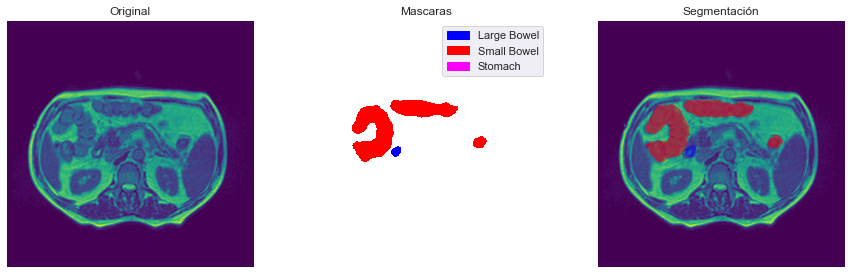

<Figure size 1080x720 with 0 Axes>

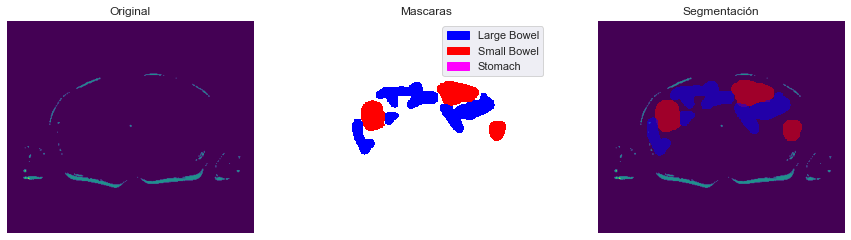

<Figure size 1080x720 with 0 Axes>

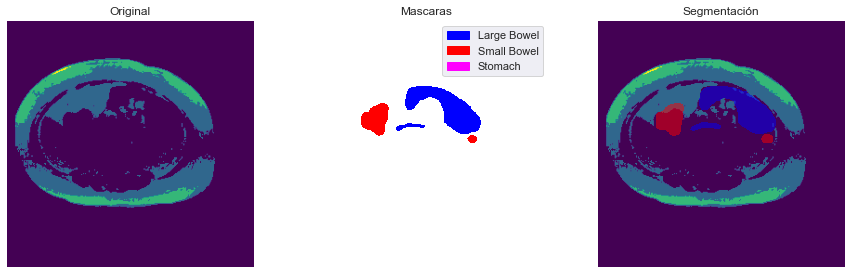

<Figure size 1080x720 with 0 Axes>

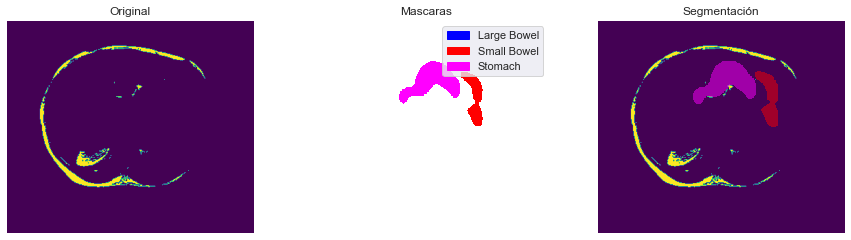

<Figure size 1080x720 with 0 Axes>

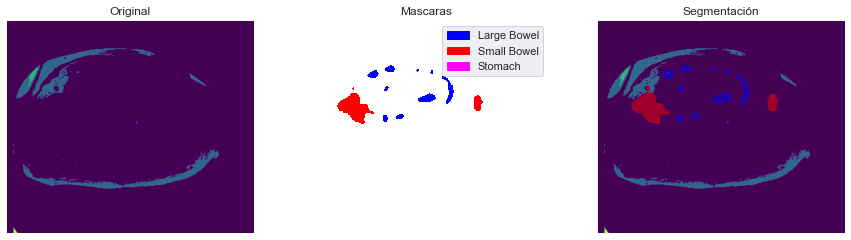

<Figure size 1080x720 with 0 Axes>

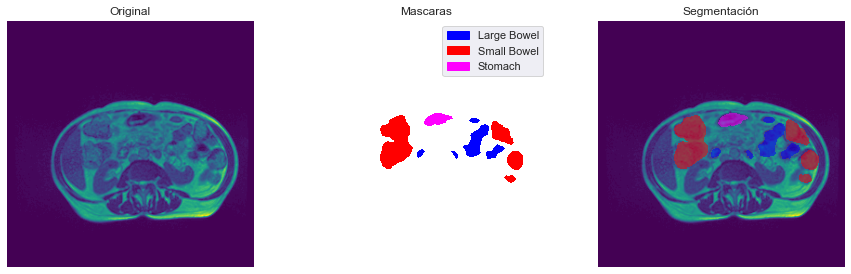

In [659]:
get_random_mask(segment, 10)

* De las máscaras se observa que no en todas las imágenes aparecen todos los organos.
* En las imágenes se observa que algunas muestran a los lados los brazos del paciente, esto podría generar ruido en el modelo.
* En cada imágen varía el tamaño de los organos.